# Pathfinder tests

The goal of this module is to test the functionality of the pathfinder modules using the pre-saved data from the fullscan pathfinder.

In [1]:
import numpy as np
import logging
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import json
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator
from logging.handlers import RotatingFileHandler
from logging import Formatter

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..\\')
from Pathfinders import *

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [2]:
def logger_setup() -> logging.Logger:
    date_time_str = time.strftime(r"%Y-%m-%d_%H-%M-%S")

    # Configure the root logger to a particular folder, format, and level.
    # Lower the level when things are working better or worse.
    root_logger = logging.getLogger()
    path = os.path.dirname('..\\')
    
    handler = RotatingFileHandler(filename=path+f"\\logging\\runtime_test.log",
        backupCount=8,encoding="utf-8")
    handler.doRollover()

    formatter = Formatter(fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    root_logger.addHandler(handler)
    root_logger.setLevel(logging.DEBUG)
    logger = logging.getLogger(__name__)
    logger.info("Debug log for the robot starting on " + date_time_str)
    return logger

# logger = logger_setup()

### Unload the data from a particular scan
This should only include data from a Fullscan module

In [3]:
path = os.path.abspath('..\\')
test_no = 6
# current_file = r"\Debugging Scripts\Scans\test_%s.json" % test_no
current_file = r"\Scans\test_%s.json" % test_no

debug_mode = True

### JSON Unpacking
Using the above file number and path, the scan data is unpacked from the corresponding JSON file. Unpacking the data can take around ~15 seconds depending on the length of the file, so a #TODO item is to create code for running a pathfinder directly off a math equation.

In [4]:
with open(path + current_file, 'r') as infile:
    json_data = json.load(infile)

r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
point_mags = json_data["points"]
scan_max = np.array(json_data["max_point"])

# indices = {'X': (0,0), 'Y': (0,1), 'Z': (0,2), 'Rx': (1,0), 'Ry': (1,1), 'Rz': (1,2)}
# points = np.array([[p[0][indices[a][0]][indices[a][1]] for a in active_rom] for p in point_mags])
# mags = np.array([p[1] for p in point_mags])

points = np.array(point_mags)
active_rom = json_data["active_ROM"]
cols = active_rom.copy()
cols.append("mag")

data = pd.DataFrame(data=points, columns=cols)

points = data[active_rom]
mags = data['mag']
mp = data.loc[data['mag'].idxmax()]

In [5]:
print(points.shape)
print(mags.shape)
linInter = LinearNDInterpolator(points,mags,fill_value=-1)

r = dict()
for DoF in r_o_m:
    r[DoF] = (r_o_m[DoF][1] - r_o_m[DoF][0]) / 2

if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(point_mags[0])
    print(type(point_mags))
    print(r_o_m)
    print(np.shape(points))
    print(r)
    print(resolution)
# Usually takes about 25 seconds for test_6

(51749, 3)
(51749,)
Active range of motion: ['Z', 'Rx', 'Ry']
[-14.0, -13.0, -12.0, 216.071]
<class 'list'>
{'X': [0, 0], 'Y': [0, 0], 'Z': [-14, 14], 'Rx': [-13, 13], 'Ry': [-13, 13], 'Rz': [0, 0]}
(51749, 3)
{'X': 0.0, 'Y': 0.0, 'Z': 14.0, 'Rx': 13.0, 'Ry': 13.0, 'Rz': 0.0}
[0.4, 1]


In [6]:
# scanner = Discrete_degree(r['Z'], r['Rx'], r['Ry'])
# scanner = DivisionDiscreteDegree(4, r['Z'], r['Rx'], r['Ry'], cutoff_mag=50)
ex = 1.5
scanner = GradientAscent(r['Z']*ex,r['Rx']*ex,r['Ry']*ex,
        bias=5,steps=4,traverse=1.6,mini_search=1)

p = scanner.next()
i = 0

offset = np.array([0,0,-3,-10,12,0])

while type(p) is not int and i < 2500:
    i += 1

    request = p + offset
    request = request[scanner.save_indices[0:-1]]
    # print(f"Reuqest: {request}")
    mag = linInter(request)

    if mag[0] == -1:
        mag[0] = i * -20
    # print(f"magnitudes:{mag}")
    # print(f"Value pushed: {np.append(p,mag[0])}")

    scanner.newMag(np.append(p,mag[0]),True)
    p = scanner.next()
    print(f"Request: {request}\t\tMag: {mag}\tpoint: {np.append(request,mag[0])},\tLoop {i}                              ",end="\r")
    # print('\n'.join(prin), end=(len(prin) + 1)*'\033[F')

print()
print(p)
if debug_mode:
    print(f"Number of points to solve: {i}")
    # print(path + output_file)

point_mags_2 = scanner.points
search_max = scanner.max_point
active_rom = scanner.active_rom

cols = active_rom.copy()
cols.append("mag")

print(len(point_mags_2))

scanner_dat = np.array(scanner.points)

scanner_data = pd.DataFrame(data=scanner_dat, columns=cols)

print(scanner_data.head())
a = np.array(point_mags_2[0])
distance = 0

for i in range(1, len(point_mags_2)):
    b = np.array(point_mags_2[i])
    t = np.sum((b - a)**2)

    distance += t**0.5
    a = b

# (x,y,z,Rx,Ry,Rz,mag) = search_max.tolist()
# search_max = (((x+offset['X'],y+offset['Y'],z+offset['Z']),(Rx+offset['Rx'],Ry+offset['Ry'],Rz+offset['Rz'])),mag)
search_max = search_max + np.append(offset.copy(),0)


t = np.sum((scan_max[:3] - search_max[:3])**2)
lin_dist = t**0.5

degree_dist = np.arccos(np.cos(np.deg2rad(scan_max[3] - search_max[3])) 
            * np.cos(np.deg2rad(scan_max[4] - search_max[4])))

print("Pathfinder evalutation: ")
print(f"\tTotal search-space distance traveled: {distance}")
print(f"\tScan max value:\t\t{scan_max}")
print(f"\tSearch max value:\t{search_max}")
print(f"\tOffsets: {offset}")
print(f"\tDistance from target to found value: {lin_dist} mm, {degree_dist} deg")

Request: [ 3.025 -0.909 -0.255]		Mag: [ 520.488]	point: [ 3.025 -0.909 -0.255  520.488],	Loop 443                                
1
Number of points to solve: 443
443
      Z    Rx   Ry        mag
0  0.00  0.00  0.0  37.233000
1  0.00  0.00  0.0  37.233000
2 -1.35 -1.35 -2.7  36.954475
3  1.35 -1.35 -2.7  36.011925
4 -1.35  1.35 -2.7  42.439950
Pathfinder evalutation: 
	Total search-space distance traveled: 8028.240457282685
	Scan max value:		[ 0.000  0.000  2.400  0.000  1.000  0.000  621.204]
	Search max value:	[ 0.000  0.000  2.375 -1.160 -0.826  0.000  604.050]
	Offsets: [  0   0  -3 -10  12   0]
	Distance from target to found value: 0.02531456980491331 mm, 0.03775014268647778 deg


(-1.35, 11.03792814953104)
(-21.90642972899135, 4.795883546912288)
(-1.35, 8.460942864331349)


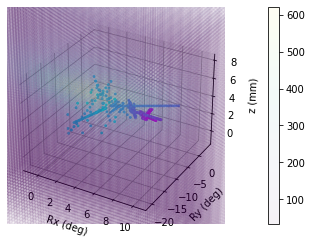

In [7]:
ax = plt.axes(projection='3d')
fig = ax.scatter(data['Rx'], data['Ry'], data['Z'], c=data['mag'], cmap='viridis', alpha=0.05, linewidth=0.02)
plt.colorbar(fig, pad=0.13,alpha=1)

# fig = ax.scatter(Rxs1, Rys1, Zs1, c=range(len(Zs1)), cmap='binary', alpha=0.8, linewidth=0.8, s=4)
fig = ax.scatter(scanner_data['Rx'], scanner_data['Ry'], scanner_data['Z'], c=range(len(scanner_data)), cmap='cool', alpha=0.8, linewidth=0.8, s=4)

ax.set_xlabel("Rx (deg)")
ax.set_ylabel("Ry (deg)")
ax.set_zlabel("z (mm)")
plt.rcParams['figure.dpi'] = 200

print((min(scanner_data['Rx']),max(scanner_data['Rx'])))
print((min(scanner_data['Ry']),max(scanner_data['Ry'])))
print((min(scanner_data['Z']),max(scanner_data['Z'])))

ax.set_xbound((min(scanner_data['Rx']),max(scanner_data['Rx'])))
ax.set_ybound((min(scanner_data['Ry']),max(scanner_data['Ry'])))
ax.set_zbound((min(scanner_data['Z']),max(scanner_data['Z'])))

# plt.savefig("fullscan_render.jpg", dpi=400)
plt.show()
# plt.axes(projection = "3d")
# plt.scatter(Rxs, Rys, Zs, c=mags, cmap='viridis', alpha=0.8, linewidth=0.5)


In [8]:
# I want to check the optimal values for traverse distance, increment size, bias, and steps. This is gonna be rough.
(trav_min, trav_max, trav_step) = (0.8,2.4,4)
(inc_min, inc_max, inc_step) = (1.4,2.2,3)
(bias_min,bias_max,bias_step) = (0,24,4)
(step_min,step_max,step_step) = (1,7,3)

# var_comparison = pd.DataFrame(columns = ['Traverse','Increment', 'bias','step',
#     'Points_visited','final_max','max_mag'])

test_vars = np.mgrid[
    trav_min:trav_max:trav_step*1j,
    inc_min:inc_max:inc_step*1j,
    bias_min:bias_max:bias_step*1j,
    step_min:step_max:step_step*1j].reshape(4,-1).T

offset = np.array([0,0,-3,-10,12,0])


In [9]:
vc = pd.DataFrame(columns = ['Traverse','Increment', 'bias','step',
    'Points_visited','final_max','max_mag'])

tot = test_vars.shape[0]

for i in range(tot):
    start_time = time.time()
    traverse=test_vars[i][0]
    inc=test_vars[i][1]
    bias=int(test_vars[i][2])
    step=int(test_vars[i][3])

    test = GradientAscent(r['Z']*ex,r['Rx']*ex,r['Ry']*ex,
        bias=bias,steps=step,traverse=traverse,inc=inc)

    p = test.next()
    j=0
    while type(p) is not int and j < 2500:
        j += 1

        request = p + offset
        request = request[test.save_indices[0:-1]]
        # print(f"Reuqest: {request}")
        mag = linInter(request)

        if mag[0] == -1:
            mag[0] = i * -20
        # print(f"magnitudes:{mag}")
        # print(f"Value pushed: {np.append(p,mag[0])}")

        test.newMag(np.append(p,mag[0]),True)
        p = test.next()
        if j % 20 == 0:
            print(f"Highest magnitude: {test.max_point[6]}\tLoop {j}\t\t\t",end="\r")
        if type(p) is int:
            j = 2500

    vc.loc[len(vc.index)] = (traverse,inc,bias,step,j,test.max_point,test.max_point[6])
    
    print(f"Test ({i}/{tot}),\ttrav={traverse:0.1f}\tinc={inc}\tbias={bias}\tstep={step}"
        f" completed in {(time.time() - start_time):0.3f} seconds.\tMax mag found {test.max_point[6]:0.2f}")
    



Test (0/144),	trav=0.8	inc=1.4	bias=0	step=1 completed in 3.323 seconds. Max mag found 422.4995698270255
Test (1/144),	trav=0.8	inc=1.4	bias=0	step=4 completed in 2.845 seconds. Max mag found 456.7488435557104
Test (2/144),	trav=0.8	inc=1.4	bias=0	step=7 completed in 1.297 seconds. Max mag found 534.2408213924451
Test (3/144),	trav=0.8	inc=1.4	bias=8	step=1 completed in 5.625 seconds. Max mag found 558.6145589616482
Test (4/144),	trav=0.8	inc=1.4	bias=8	step=4 completed in 0.989 seconds. Max mag found 59.80355141985664
Test (5/144),	trav=0.8	inc=1.4	bias=8	step=7 completed in 1.000 seconds. Max mag found 59.761135556207236
Test (6/144),	trav=0.8	inc=1.4	bias=16	step=1 completed in 6.772 seconds. Max mag found 588.0781413622569
Test (7/144),	trav=0.8	inc=1.4	bias=16	step=4 completed in 1.140 seconds. Max mag found 59.70490736001027
Test (8/144),	trav=0.8	inc=1.4	bias=16	step=7 completed in 0.998 seconds. Max mag found 59.68531504165206
Test (9/144),	trav=0.8	inc=1.4	bias=24	step=1 compl

In [12]:
print(vc.head())
print(vc.tail())

path = os.path.abspath('..\\')
test_no = 6
# current_file = r"\Debugging Scripts\Scans\test_%s.json" % test_no
current_file = path + r"\parameter_check.csv"

vc.to_csv(current_file)

   Traverse  Increment  bias  step  Points_visited  \
0       0.8        1.4     0     1            2500   
1       0.8        1.4     0     4            2500   
2       0.8        1.4     0     7            2500   
3       0.8        1.4     8     1            2500   
4       0.8        1.4     8     4            2500   

                                           final_max     max_mag  
0  [0.0, 0.0, 5.431465500936235, 4.99779813012324...  422.499570  
1  [0.0, 0.0, 5.596632377121074, 5.47916890207925...  456.748844  
2  [0.0, 0.0, 5.420371694966291, 6.80701632650337...  534.240821  
3  [0.0, 0.0, 5.665398192285769, 7.84260934493298...  558.614559  
4  [0.0, 0.0, 0.013828487493406304, 0.09194042813...   59.803551  
     Traverse  Increment  bias  step  Points_visited  \
139       2.4        2.2    16     4            2500   
140       2.4        2.2    16     7            2500   
141       2.4        2.2    24     1            2500   
142       2.4        2.2    24     4            2